In [1]:
class bcolors:
    OK = '\033[92m' #GREEN
    WARNING = '\033[93m' #YELLOW
    FAIL = '\033[91m' #RED
    RESET = '\033[0m' #RESET COLOR

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Sampler, SubsetRandomSampler
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

import albumentations as A
from albumentations.pytorch import ToTensorV2

from math import ceil
import seaborn as sn

In [3]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report, balanced_accuracy_score

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{bcolors.OK}{device}{bcolors.RESET}')

cuda:0


In [4]:
# set the attempt number in attempt
# # set the model name in model
# set the model version in version

hyper_parameter = {
    "attempt": 'custom_model',
    "model": 'v1',
    "version": '.8',
    "learning_rate": 0.001,
    "batch_size": 8,
    "num_workers": 2,
    "no_epochs": 50,
    "image_size": 224, 
    "in_channels": 3, 
    "num_classes": 8,
    "load_model": True
}

In [16]:
# set data directory
data_dir = '../Images/images2/'
sets = ['train', 'test']
# to use checkpoint saving create a directory named "checkpoint" and a sub directory in the name of the model
checkpoint_path = f'./checkpoints/{hyper_parameter["model"]}{hyper_parameter["version"]}-{hyper_parameter["attempt"]}'


print(f'{bcolors.OK}Enviroment setup complete 😊🐼!{bcolors.RESET}')

Enviroment setup complete 😊🐼!


In [17]:
classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']

train_class_frequency = []
for classname in iter(classes):
    train_class_frequency.append(len(os.listdir(os.path.join(data_dir, 'train', classname))))

image_frequency = pd.DataFrame(columns=sets, index=classes)

for dataset in iter(sets):
    for classname in iter(classes):
        image_frequency[dataset][classname] = len(os.listdir(os.path.join(data_dir, dataset, classname)))
image_frequency.index = image_frequency.index.rename('classes')

print(image_frequency.to_markdown())
print(image_frequency.sum(axis=0))

image_ratio = pd.DataFrame(columns=sets, index=classes)
for dataset in iter(sets):
    for classname in iter(classes):
        image_ratio[dataset][classname] = (image_frequency[dataset][classname] / image_frequency[dataset].sum())*100
image_ratio.index = image_frequency.index.rename('classes')
print(image_ratio.to_markdown())

| classes   |   train |   test |
|:----------|--------:|-------:|
| AK        |     681 |    186 |
| BCC       |    2619 |    704 |
| BKL       |    2114 |    510 |
| DF        |     185 |     54 |
| MEL       |    3623 |    899 |
| NV        |   10335 |   2540 |
| SCC       |     506 |    122 |
| VASC      |     202 |     51 |
train    20265
test      5066
dtype: object
| classes   |     train |     test |
|:----------|----------:|---------:|
| AK        |  3.36047  |  3.67154 |
| BCC       | 12.9238   | 13.8966  |
| BKL       | 10.4318   | 10.0671  |
| DF        |  0.912904 |  1.06593 |
| MEL       | 17.8781   | 17.7458  |
| NV        | 50.9993   | 50.1382  |
| SCC       |  2.49692  |  2.40821 |
| VASC      |  0.996792 |  1.00671 |


In [18]:
class Transforms:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, *args, **kwargs):
        return self.transforms(image=np.array(img))['image']

In [19]:
# set the mean and std based on the model documentation
# for efficient net bo - pytorch documentation
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
# hyper_parameter['image_size']=32

data_transforms = {
    'train': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()]),
    'test': A.Compose([A.Resize(hyper_parameter['image_size'] , hyper_parameter['image_size']), A.Normalize(mean, std), ToTensorV2()])
}

In [10]:
# create dataset and dataloader
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform =Transforms(transforms=data_transforms[x])) for x in sets}

In [11]:
# idx2class = {v: k for k, v in image_datasets['train'].class_to_idx.items()}
# idx2class

In [12]:
# targets = np.array(image_datasets['train'].targets)
# idxs = np.where(targets==0)[0]
# len(idxs)


In [13]:
# # ratio_of=hyper_parameter['batch_size']
# # ratio_of = len(image_datasets['train'])
# # if we consider trainset (0.80) to be 10,360 the total dataset 12,950 (1.00)
# # test would be 2,590 (0.20)
# ratio_of = 5066
# class_ratio=0.125
# targets = np.array(image_datasets['test'].targets)
# ak_idxs = np.where(targets==0)[0]
# bcc_idxs = np.where(targets==1)[0]
# bkl_idxs = np.where(targets==2)[0]
# df_idxs = np.where(targets==3)[0]
# mel_idxs = np.where(targets==4)[0]
# nv_idxs = np.where(targets==5)[0]
# scc_idxs = np.where(targets==6)[0]
# vasc_idxs = np.where(targets==7)[0]
# ak = np.random.choice(ak_idxs, int(ratio_of * class_ratio), replace=True)
# bcc = np.random.choice(bcc_idxs, int(ratio_of * class_ratio), replace=True)
# bkl = np.random.choice(bkl_idxs, int(ratio_of * class_ratio), replace=True)
# df = np.random.choice(df_idxs, int(ratio_of * class_ratio), replace=True)
# mel = np.random.choice(mel_idxs, int(ratio_of * class_ratio), replace=False)
# nv = np.random.choice(nv_idxs, int(ratio_of * class_ratio), replace=True)
# scc = np.random.choice(scc_idxs, int(ratio_of * class_ratio), replace=True)
# vasc = np.random.choice(vasc_idxs, int(ratio_of * class_ratio), replace=True)
# idxs = np.hstack([ak, bcc, bkl, df, mel, nv, scc, vasc])
# np.random.shuffle(idxs)

# print(len(ak))
# print(len(idxs)==len(ak)*8)


In [ ]:
# class_counts = train_class_frequency
# class_weights = np.zeros_like(len(image_datasets['train']), dtype=np.float16)
# median_freq = np.median(class_counts)
# class_weights = [median_freq/c for c in class_counts]

# sample_weights = [0] * len(image_datasets['train'])
# for idx, (data, label) in enumerate(image_datasets['train']):
#     class_weight = class_weights[label]
#     sample_weights[idx] = class_weight

# medianSampler = WeightedRandomSampler(sample_weights, sum(train_class_frequency))

# for w in class_weights:
#     print(f'{(w*100):2f}')

In [20]:
# Ensure an equal number of representatives from each class in each batch
# The class_counts variable is a list that contains the number of samples in each class. 
# The weights variable is then created by taking the reciprocal of each class count and normalizing the values so that they sum to 1. 
# This gives each class an equal probability of being selected. Then the WeightedRandomSampler is instantiated with the weights and the number of samples. 
# Finally, the DataLoader is instantiated with the dataset, the desired batch size, and the sampler.

class_counts = train_class_frequency # list of number of samples per class
# weights = [1/c for c in class_counts]
# weights = [w/sum(weights) for w in weights]
weights = [0.09722467, 0.02536677, 0.03212416, 0.35269368, 0.01864082, 0.00654709, 0.13422578, 0.33317703]
sample_weights = [0] * len(image_datasets['train'])

for idx, (data, label) in enumerate(image_datasets['train']): # type: ignore
    class_weight = weights[label]
    sample_weights[idx] = class_weight

weightedSampler = WeightedRandomSampler(sample_weights, sum(train_class_frequency))

for w in weights:
    print(f'{(w):2f}')

0.097225
0.025367
0.032124
0.352694
0.018641
0.006547
0.134226
0.333177


In [16]:
# # oversampling
# # setting weights to each sample based on class population
# class_weights = []
# for root, subdir, files in os.walk(os.path.join(data_dir, "train")):
#     if len(files) > 0:
#         class_weights.append(1/len(files))

# sample_weights = [0] * len(image_datasets['train'])

# for idx, (data, label) in enumerate(image_datasets['train']):
#     class_weight = class_weights[label]
#     sample_weights[idx] = class_weight

# overSampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
# class_weights

In [17]:
# # under sample and over sample based on flags 
# # if we consider trainset (0.80) to be 10,360 the total dataset 12,950 (1.00)
# # test would be 2,590 (0.20)
# class RatioSampler(Sampler):
#     def __init__(self, dataset, flags, is_test=False, class_ratio=0.125):
#         self.dataset = dataset
#         if(is_test):
#             # put custom test length
#             self.n = 2590
#         else:
#             self.n = len(dataset)
#         self.class_ratio = class_ratio
#         self.flags = flags
    
#     def __iter__(self):
#         targets = np.array(self.dataset.targets)
#         ak_idxs = np.where(targets==0)[0]
#         bcc_idxs = np.where(targets==1)[0]
#         bkl_idxs = np.where(targets==2)[0]
#         df_idxs = np.where(targets==3)[0]
#         mel_idxs = np.where(targets==4)[0]
#         nv_idxs = np.where(targets==5)[0]
#         scc_idxs = np.where(targets==6)[0]
#         vasc_idxs = np.where(targets==7)[0]
#         ak = np.random.choice(ak_idxs, int(self.n * self.class_ratio), replace=self.flags[0])
#         bcc = np.random.choice(bcc_idxs, int(self.n * self.class_ratio), replace=self.flags[1])
#         bkl = np.random.choice(bkl_idxs, int(self.n * self.class_ratio), replace=self.flags[2])
#         df = np.random.choice(df_idxs, int(self.n * self.class_ratio), replace=self.flags[3])
#         mel = np.random.choice(mel_idxs, int(self.n * self.class_ratio), replace=self.flags[4])
#         nv = np.random.choice(nv_idxs, int(self.n * self.class_ratio), replace=self.flags[5])
#         scc = np.random.choice(scc_idxs, int(self.n * self.class_ratio), replace=self.flags[6])
#         vasc = np.random.choice(vasc_idxs, int(self.n * self.class_ratio), replace=self.flags[7])
#         idxs = np.hstack([ak, bcc, bkl, df, mel, nv, scc, vasc])
#         np.random.shuffle(idxs)
#         return iter(idxs)

#     def __len__(self):
#         return self.n

In [18]:
# class EqualDataLoader(Dataset):
#     def __init__(self, dataset, class_counts):
#         self.dataset = dataset
#         self.class_counts = class_counts
#         self.class_samples = []
#         for i in range(len(class_counts)):
#             self.class_samples.append([j for j in range(len(dataset)) if dataset[j][1] == i])

#     def __getitem__(self, index):
#         class_idx = index % len(self.class_counts)
#         sample_idx = np.random.choice(self.class_samples[class_idx])
#         return self.dataset[sample_idx]

#     def __len__(self):
#         return sum(self.class_counts)

In [21]:
# dataloaders = {x: DataLoader(image_datasets[x], batch_size=hyper_parameter['batch_size'], shuffle=True) for x in sets}

# train_flags = [True, True, True, True, True, False, True, True]
# test_flags = [True, True, True, True, True, False, True, True]

# dataloaders = {
#     'train': DataLoader(image_datasets['train'], batch_size=hyper_parameter['batch_size'], sampler=RatioSampler(dataset=image_datasets['train'], flags=train_flags)),
#     'test': DataLoader(image_datasets['test'], batch_size=hyper_parameter['batch_size'], sampler=RatioSampler(image_datasets['test'], flags=test_flags, is_test=True))
# }

# dataloaders = {
#     'train': DataLoader(image_datasets['train'], batch_size=hyper_parameter['batch_size'], sampler=RatioSampler(image_datasets['train'], flags=train_flags)),
#     'test': DataLoader(image_datasets['test'], batch_size=hyper_parameter['batch_size'], sampler=RatioSampler(image_datasets['test'], flags=test_flags))
# }

# medianLoader = DataLoader(image_datasets['train'], batch_size=hyper_parameter['batch_size'], sampler=medianSampler)

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=hyper_parameter['batch_size'], sampler=weightedSampler),
    'test': DataLoader(image_datasets['test'], batch_size=hyper_parameter['batch_size'], shuffle=True)
}

dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes

print('train: {} test: {}'.format(dataset_sizes['train'], dataset_sizes['test']))
print(class_names)

train: 25331 test: 320
['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


In [22]:
# Train Loader - count the frequency of images in every iteration
num_ak, num_bcc, num_bkl, num_df, num_mel, num_nv, num_scc, num_vasc = 0,0,0,0,0,0,0,0
for data, labels in dataloaders['train']:
    num_ak += torch.sum(labels==0)
    num_bcc += torch.sum(labels==1)
    num_bkl += torch.sum(labels==2)
    num_df += torch.sum(labels==3)
    num_mel += torch.sum(labels==4)
    num_nv += torch.sum(labels==5)
    num_scc += torch.sum(labels==6)
    num_vasc += torch.sum(labels==7)
print(f'AK: {num_ak}, BCC: {num_bcc}, BKL: {num_bkl}, DF: {num_df}, MEL: {num_mel}, NV: {num_nv}, SCC: {num_scc}, VASC: {num_vasc}')
print(f'{num_ak+num_bcc+num_bkl+num_df+num_mel+num_nv+num_scc+num_vasc}')

AK: 2534, BCC: 2584, BKL: 2492, DF: 2570, MEL: 2493, NV: 2561, SCC: 2542, VASC: 2489
20265


In [21]:
# # Train Loader - count the frequency of images in every iteration
# num_ak, num_bcc, num_bkl, num_df, num_mel, num_nv, num_scc, num_vasc = 0,0,0,0,0,0,0,0
# for data, labels in medianLoader:
#     num_ak += torch.sum(labels==0)
#     num_bcc += torch.sum(labels==1)
#     num_bkl += torch.sum(labels==2)
#     num_df += torch.sum(labels==3)
#     num_mel += torch.sum(labels==4)
#     num_nv += torch.sum(labels==5)
#     num_scc += torch.sum(labels==6)
#     num_vasc += torch.sum(labels==7)
# print(f'AK: {num_ak}, BCC: {num_bcc}, BKL: {num_bkl}, DF: {num_df}, MEL: {num_mel}, NV: {num_nv}, SCC: {num_scc}, VASC: {num_vasc}')
# print(f'{num_ak+num_bcc+num_bkl+num_df+num_mel+num_nv+num_scc+num_vasc}')

In [22]:
# # Test Loader - count the frequency of images in every iteration
# num_ak, num_bcc, num_bkl, num_df, num_mel, num_nv, num_scc, num_vasc = 0,0,0,0,0,0,0,0
# for data, labels in dataloaders['test']:
#     num_ak += torch.sum(labels==0)
#     num_bcc += torch.sum(labels==1)
#     num_bkl += torch.sum(labels==2)
#     num_df += torch.sum(labels==3)
#     num_mel += torch.sum(labels==4)
#     num_nv += torch.sum(labels==5)
#     num_scc += torch.sum(labels==6)
#     num_vasc += torch.sum(labels==7)
# print(f'AK: {num_ak}, BCC: {num_bcc}, BKL: {num_bkl}, DF: {num_df}, MEL: {num_mel}, NV: {num_nv}, SCC: {num_scc}, VASC: {num_vasc}')
# print(f'{num_ak+num_bcc+num_bkl+num_df+num_mel+num_nv+num_scc+num_vasc}')

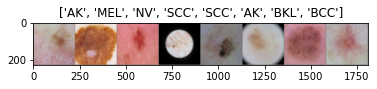

In [23]:
# Helper function for inline image display
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

images, classes = next(iter(dataloaders['train']))

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
imshow(img_grid, title=[class_names[x] for x in classes])

In [6]:
class CustomModel(nn.Module):
    def __init__(self, out_classes):
        super(CustomModel, self).__init__()
        self.out_classes = out_classes
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),
            # 224 -> 74
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),
            # 112 -> 56
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            # nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(256),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),
            # 56 -> 28
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3),
            # 28 -> 14

        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, out_classes),
            nn.ReLU(),
            nn.BatchNorm1d(out_classes)
        )
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(-1, 256 * 2 * 2)
        x = self.classifier(x)
        return x

In [25]:
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
    
#     def forward(self, x):
#         return x

In [7]:
# version = hyper_parameter['version']
model = CustomModel(hyper_parameter['num_classes'])

In [8]:
# define model and optimizers
model.to(device)

next(model.parameters()).device

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = hyper_parameter['learning_rate'])

# scheduler
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
reduce_on_plateau_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=4, verbose=True)

In [10]:
# view model architecture
# print(model)
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3           [-1, 32, 74, 74]               0
       BatchNorm2d-4           [-1, 32, 74, 74]              64
            Conv2d-5           [-1, 64, 74, 74]          18,496
              ReLU-6           [-1, 64, 74, 74]               0
            Conv2d-7           [-1, 64, 74, 74]          36,928
              ReLU-8           [-1, 64, 74, 74]               0
         MaxPool2d-9           [-1, 64, 24, 24]               0
      BatchNorm2d-10           [-1, 64, 24, 24]             128
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
           Conv2d-13          [-1, 128, 24, 24]         147,584
             ReLU-14          [-1, 128,

In [29]:
train_results = {
    'accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'balanced_accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'f1_score': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'loss': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'cf_matrix': np.zeros((hyper_parameter['num_classes'], hyper_parameter['num_classes']), dtype=float)
}

test_results = {
    'accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'balanced_accuracy': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'f1_score': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'loss': np.zeros(hyper_parameter['no_epochs'], dtype=float),
    'cf_matrix': np.zeros((hyper_parameter['num_classes'], hyper_parameter['num_classes']), dtype=float)
}

results = {
    'train': train_results,
    'test': test_results
}

In [30]:
save_path = f'{checkpoint_path}.pth.tar'
print(f'Save Path: {save_path}')

def save_checkpoint(state, epoch, filename = save_path):
    print(f'=> Checkpoint at {epoch + 1} saved!')
    print(f'Saved at: {save_path}')
    torch.save(state, filename)

def load_checkpoint(checkpoint):
    print(f'=> Loading Checkpoint')
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

Save Path: ./checkpoints/v1.8-custom_model.pth.tar


In [31]:
def train_model(model, cirterion, optimizer, scheduler, num_epochs = 1):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  best_f1_scr = 0.0
  # initialize the early stopping counter
  early_stopping_counter = 0
  early_stopping_threshold = 10
  best_test_loss = float('inf')

  epoch_preds = {}
  epoch_targets = {}

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))
    print('-' * 15)

    for phase in ['train', 'test']:
      if phase =='train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      real_targets = []
      predicted_targets = []

      # Iterate over data.
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history only if train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          
          real_targets.extend(labels.detach().cpu().numpy())
          predicted_targets.extend(preds.detach().cpu().numpy())

          loss = cirterion(outputs, labels)

          # backward + optimize only if in train
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
      ### EPOCH Train & Test ###
      # if phase == 'train':
      #   scheduler.step()

      epoch_f1_score = f1_score(real_targets, predicted_targets, average='micro')
      epoch_balanced_acc = balanced_accuracy_score(real_targets, predicted_targets)
      epoch_cf_matrix = confusion_matrix(real_targets, predicted_targets)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects / dataset_sizes[phase]

      if phase == 'test':
        epoch_preds[epoch] = predicted_targets
        epoch_targets[epoch] = real_targets
        scheduler.step(epoch_acc)

      results[phase]['accuracy'][epoch] = epoch_acc
      results[phase]['balanced_accuracy'][epoch] = epoch_balanced_acc
      results[phase]['loss'][epoch] = epoch_loss
      results[phase]['f1_score'][epoch] = epoch_f1_score
      results[phase]['cf_matrix'] += epoch_cf_matrix

      # printing epoch resutlts
      if (epoch + 1) % 2 == 0:
        print(f'{phase} Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')
        print(f'{phase} Balanced Acc: {epoch_balanced_acc:.4f}, F1: {epoch_f1_score:.4f}')

      epoch_time = time.time() - since
      print(f'Epoch time: {epoch_time // 60:.0f}m {epoch_time %  60:.0f}s')

      if phase == 'test' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      
      if phase == 'test' and epoch_f1_score > best_f1_scr:
        best_f1_scr = epoch_f1_score
      
      if epoch_loss < best_test_loss or epoch_acc > best_acc:
        best_test_loss = epoch_loss
        best_acc = epoch_acc
        early_stopping_counter = 0
      else:
        early_stopping_counter += 1
      # check if the early stopping threshold has been reached
      # if early_stopping_counter >= early_stopping_threshold:
    
    if (epoch + 1) % 2 == 0:
      checkpoint = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
      }
      save_checkpoint(checkpoint, epoch)

    print()
    ######################################################

  # training Complete
  # printing time require to train model
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m { time_elapsed % 60:.0f}s')

  t = time.localtime()
  current_time = time.strftime("%H:%M", t)
  print(f'Trainig completed at {current_time}')
  print(f'Best test Acc: {best_acc:4f}')
  print(f'Best F1 : {best_f1_scr:4f}')
  print(f"Balance Acc F1 : {results['test']['balanced_accuracy'][num_epochs-1]:4f}")

  # normalize cf matrix
  for phase in ['train', 'test']:
    cf_matrix_normalized = results[phase]['cf_matrix'] / results[phase]['cf_matrix'].sum(axis=1, keepdims=True)
    df_cm = pd.DataFrame(cf_matrix_normalized, index = class_names, columns = class_names)
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_cf_matrix.svg')
  plt.show()

  for phase in ['train', 'test']:
    plt.plot(results[phase]['accuracy'], label='{} accuracy'.format(phase))
    plt.title(f'{hyper_parameter["model"]} {hyper_parameter["version"]} learning rate: {hyper_parameter["learning_rate"]} epoch: {hyper_parameter["no_epochs"]}')
    plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_accuracy.svg')
  plt.show()

  for phase in ['train', 'test']:
    plt.plot(results[phase]['balanced_accuracy'], label='{} balanced accuracy'.format(phase))
    plt.title(f'{hyper_parameter["model"]} {hyper_parameter["version"]} learning rate: {hyper_parameter["learning_rate"]} epoch: {hyper_parameter["no_epochs"]}')
    plt.legend(bbox_to_anchor = (1.6, 1), loc='upper right')
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_balanced-accuracy.svg')
  plt.show()

  for phase in ['train', 'test']:
    plt.plot(results[phase]['f1_score'], label='{} f1 score'.format(phase))
    plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_f1_score.svg')
  plt.show()
  
  for phase in ['train', 'test']:
    plt.plot(results[phase]['loss'], label='{} loss'.format(phase))
    plt.title(f'{hyper_parameter["model"]} {hyper_parameter["version"]} learning rate: {hyper_parameter["learning_rate"]} epoch: {hyper_parameter["no_epochs"]}')
    plt.legend(bbox_to_anchor = (1.45, 1), loc='upper right')
    plt.tight_layout()
  plt.savefig(f'{checkpoint_path}_loss.svg')
  plt.show()

  last_epoch = num_epochs - 1
  preds = epoch_preds[last_epoch]
  targets = epoch_targets[last_epoch]
  print('Test Classification Report')
  print(classification_report(targets, preds))

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

In [32]:
# hyper_parameter['attempt'] = 'custom_sampler-loader-full_dataset-updatedmetric'
# # hyper_parameter['attempt'] = hyper_parameter['attempt']+'-retrained'

# # load_path = f'{checkpoint_path}.pth.tar'
# # load_path = "./checkpoints/efficientnet/efficientnetb0-custom_sampler-full_dataset.pth.tar"
# load_path =  "checkpoints/v1.1-custom_model.pth.tar"
# if hyper_parameter['load_model']:
#     load_checkpoint(torch.load(load_path))

In [33]:
# weights = dict()
# for name, para in model.named_parameters():
#     weights[name] = para
# print(weights)

Epoch 1/50
---------------
Epoch time: 13m 20s
Epoch time: 13m 27s

Epoch 2/50
---------------
train Loss: 1.7709, Acc: 0.3232
train Balanced Acc: 0.3239, F1: 0.3232
Epoch time: 26m 51s
test Loss: 1.8450, Acc: 0.2875
test Balanced Acc: 0.2875, F1: 0.2875
Epoch time: 26m 58s
=> Checkpoint at 2 saved!
Saved at: ./checkpoints/v1.8-custom_model.pth.tar

Epoch 3/50
---------------
Epoch time: 40m 22s
Epoch time: 40m 28s

Epoch 4/50
---------------
train Loss: 1.5985, Acc: 0.3939
train Balanced Acc: 0.3921, F1: 0.3939
Epoch time: 53m 52s
test Loss: 1.8188, Acc: 0.4563
test Balanced Acc: 0.4562, F1: 0.4562
Epoch time: 53m 59s
=> Checkpoint at 4 saved!
Saved at: ./checkpoints/v1.8-custom_model.pth.tar

Epoch 5/50
---------------
Epoch time: 67m 21s
Epoch time: 67m 28s

Epoch 6/50
---------------
train Loss: 1.3870, Acc: 0.4839
train Balanced Acc: 0.4833, F1: 0.4839
Epoch time: 80m 54s
test Loss: 1.2396, Acc: 0.5563
test Balanced Acc: 0.5563, F1: 0.5563
Epoch time: 81m 0s
=> Checkpoint at 6 sav

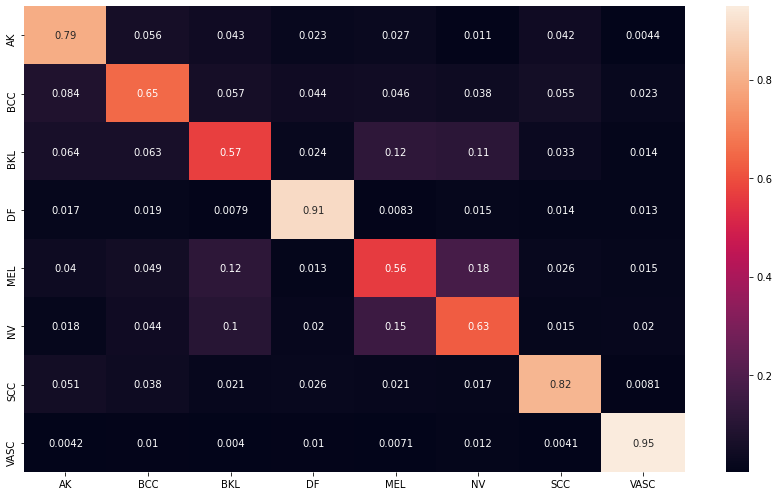

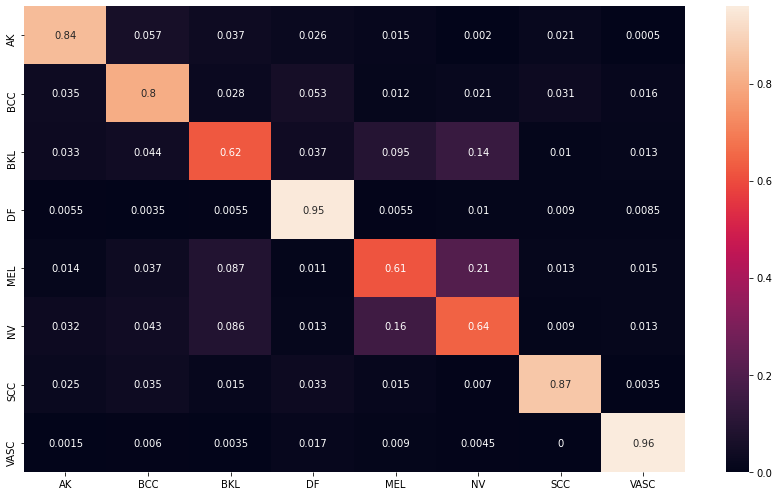

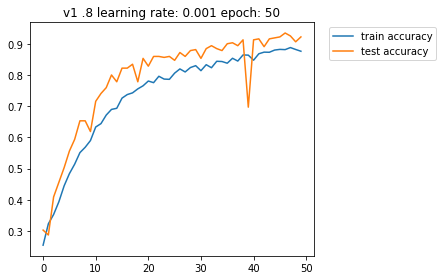

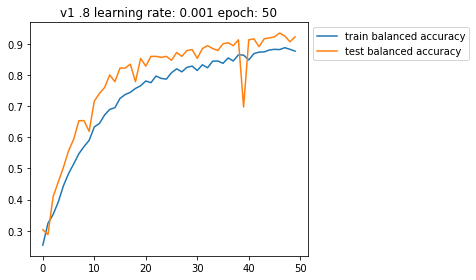

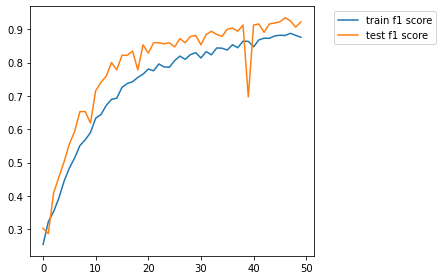

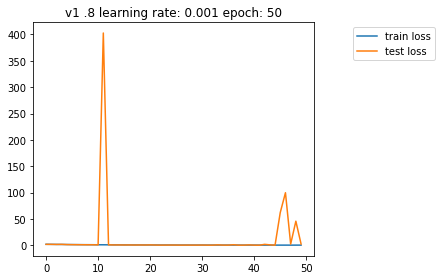

Test Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       0.95      1.00      0.98        40
           2       0.93      0.95      0.94        40
           3       1.00      1.00      1.00        40
           4       0.78      0.72      0.75        40
           5       0.73      0.75      0.74        40
           6       1.00      1.00      1.00        40
           7       1.00      0.95      0.97        40

    accuracy                           0.92       320
   macro avg       0.92      0.92      0.92       320
weighted avg       0.92      0.92      0.92       320



In [34]:
model = train_model(model, criterion, optimizer, reduce_on_plateau_scheduler, num_epochs=hyper_parameter['no_epochs'])

In [35]:
# for param_group in optimizer.param_groups:
#     print(param_group['lr'])

In [36]:
# # Export to CSV
# for phase in ['train', 'test']:
#     for metric in ['accuracy', 'loss', 'balanced_accuracy']:
#         df = pd.DataFrame(results[phase][metric])
#         df.to_csv(f'E:/Data/ISIC2019/custom-model-results/{hyper_parameter["model"]}-{hyper_parameter["version"]}-{phase}-{metric}-{hyper_parameter["attempt"]}.csv', mode='a')

# Methods to try
https://stackoverflow.com/questions/62319228/number-of-instances-per-class-in-pytorch-dataset

https://discuss.pytorch.org/t/get-current-lr-of-optimizer-with-adaptive-lr/24851
https://github.com/pytorch/pytorch/issues/2830#issuecomment-336194949